In [1]:
import os
import json
import librosa
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from data_loader import TANG
from utils import *
from model import AutoEncoderRNN
from train_model import train_model

device=torch.device('cuda:0')
sequence_length = 10

dataset=TANG(seq_len=sequence_length, dataset_location='data/', normalize=True)
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.15 * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

Loading the dataset...
Loading file tang.pickle


In [2]:
import torch.nn.functional as F
class DenseAE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DenseAE, self).__init__()
        self.encoder1 = nn.Linear(input_dim, 2*hidden_dim)
        self.encoder2 = nn.Linear(2*hidden_dim, hidden_dim)
        #self.encoder3 = nn.Linear(2*hidden_dim, hidden_dim)
        #self.decoder3 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.decoder2 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.decoder1 = nn.Linear(2*hidden_dim, input_dim)
        
    def forward(self, x):
        x = F.relu(self.encoder1(x))
        x = F.relu(self.encoder2(x))
        #x = F.relu(self.encoder3(x))
        #x = F.relu(self.decoder3(x))
        x = F.relu(self.decoder2(x))
        x = self.decoder1(x)
        return x
    

In [5]:
num_epochs = 125
learning_rate = 1e-3
batch_size = 500
input_size = 69
hidden_size = 16

data_loaders={}
dataset_sizes = {}
data_loaders['train'] = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
data_loaders['val'] = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
dataset_sizes['val'] = len(test_indices)
dataset_sizes['train'] = len(train_indices)
print("Number of training/test patches:", (len(train_indices),len(test_indices)))

model = DenseAE(input_size, hidden_size)

model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

Number of training/test patches: (85715, 15126)
DenseAE(
  (encoder1): Linear(in_features=69, out_features=32, bias=True)
  (encoder2): Linear(in_features=32, out_features=16, bias=True)
  (decoder2): Linear(in_features=16, out_features=32, bias=True)
  (decoder1): Linear(in_features=32, out_features=69, bias=True)
)


In [6]:
import copy
import time
losses = {'train': [], 'val': []}
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 100
with tqdm(total = num_epochs) as pb:
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'val':
                # scheduler.step()
                model.eval()
            else:
                model.train()
            running_loss = 0.0
            
            for step, (moves, uid, series_uid) in enumerate(data_loaders[phase]):
                moves = moves.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase != 'val'):
                    outputs = model(moves)
                    loss = criterion(outputs, moves)
                    if phase != 'val':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() 
            epoch_loss = running_loss * batch_size / dataset_sizes[phase]
            losses[phase].append(epoch_loss) 
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            pb.set_description('Epoch {} / {}  {} Loss: {:4f}'.format(epoch + 1, num_epochs, phase, epoch_loss))
        pb.update(1)
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))
model.load_state_dict(best_model_wts)

KeyboardInterrupt: 

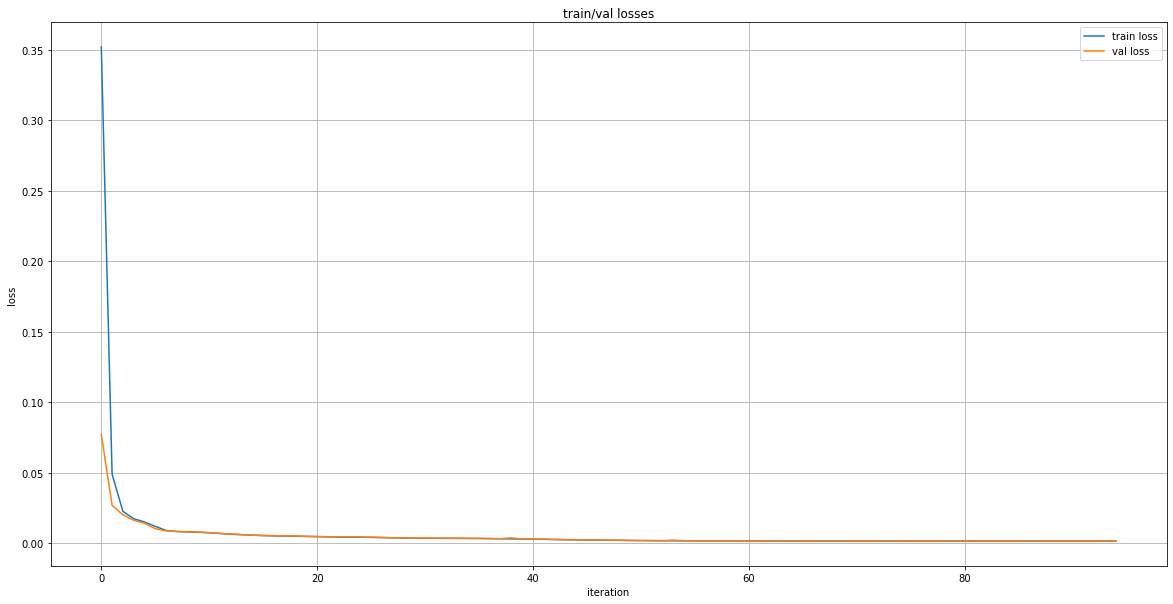

In [7]:
plt.figure(figsize=(20, 10))

for phase in ['train', 'val']:
    plt.plot(losses[phase], label='{} loss'.format(phase))
 
plt.legend()

plt.title('train/val losses')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.grid(True)

In [ ]:
moves, uid, suid = dataset.__getitem__(0)
moves = moves*dataset.std + dataset.mean
moves

In [ ]:
model(moves.to(device)).cpu()*dataset.std + dataset.mean

10


<IPython.core.display.Javascript object>


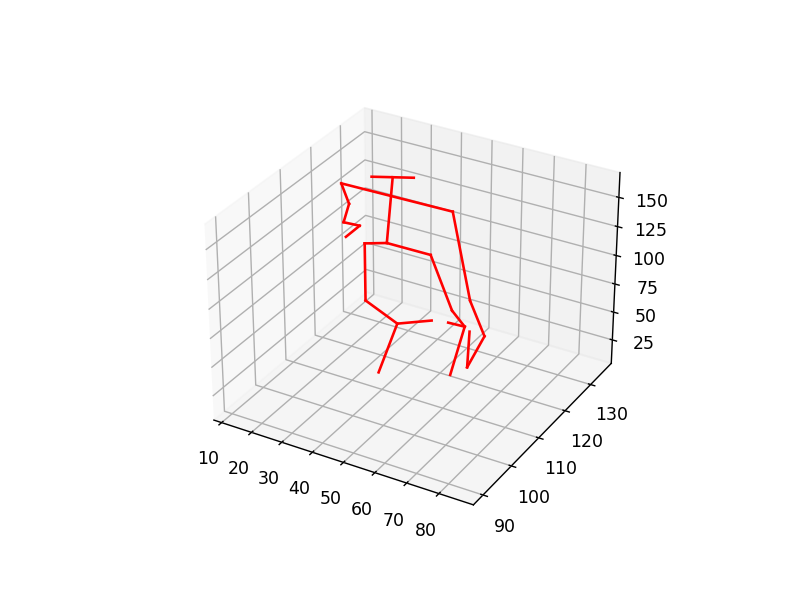

<IPython.core.display.Javascript object>


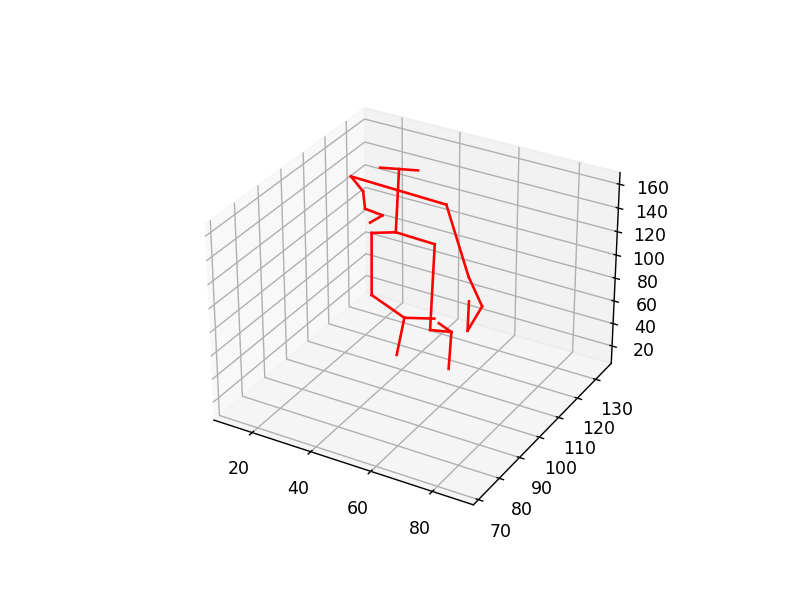

<IPython.core.display.Javascript object>


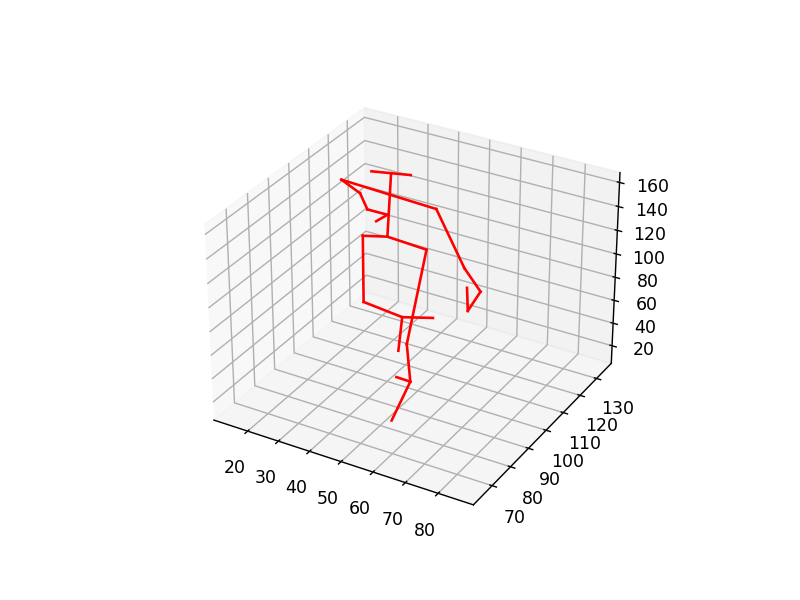

<IPython.core.display.Javascript object>


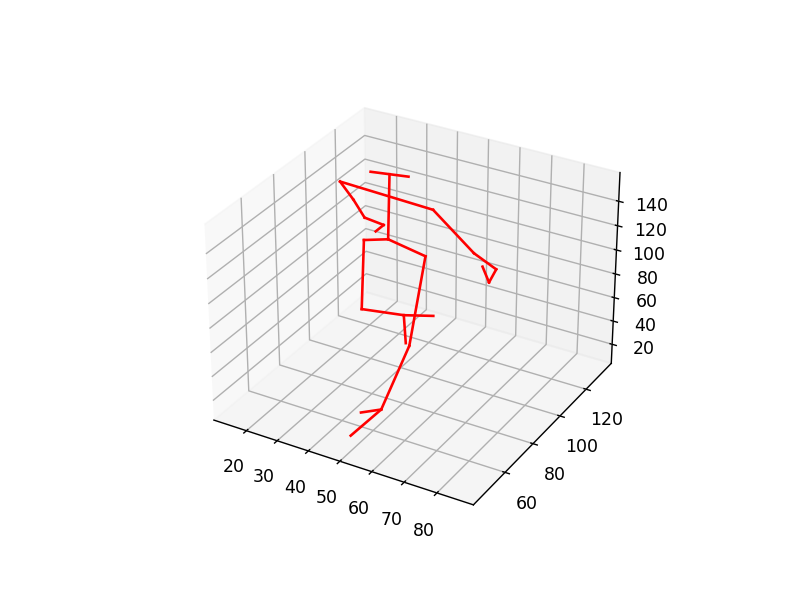

<IPython.core.display.Javascript object>


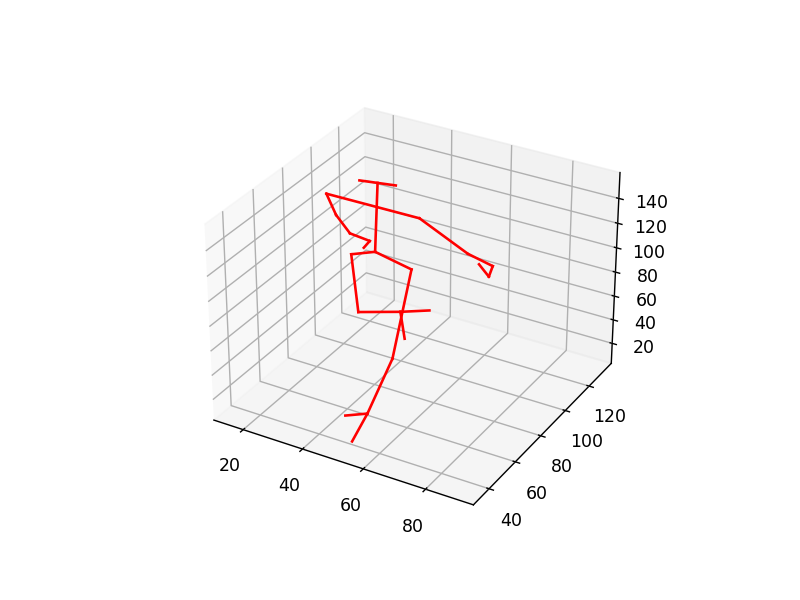

<IPython.core.display.Javascript object>


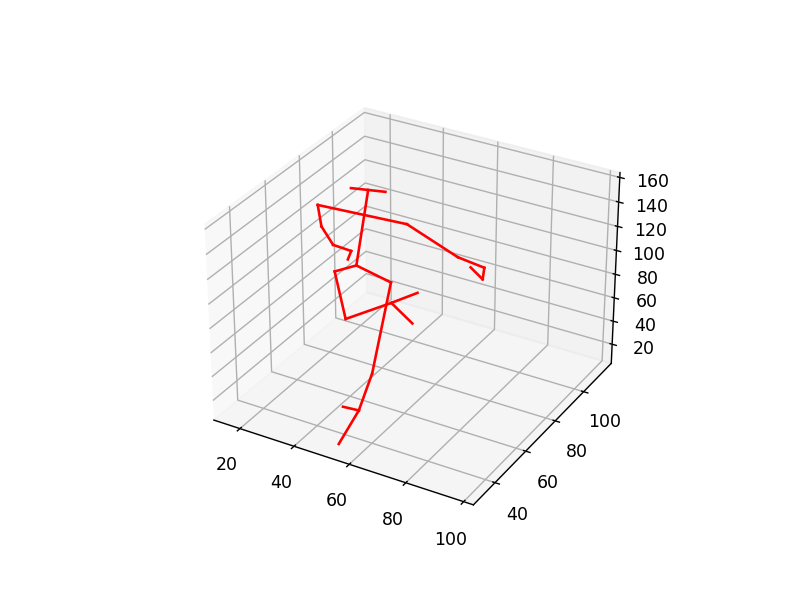

<IPython.core.display.Javascript object>


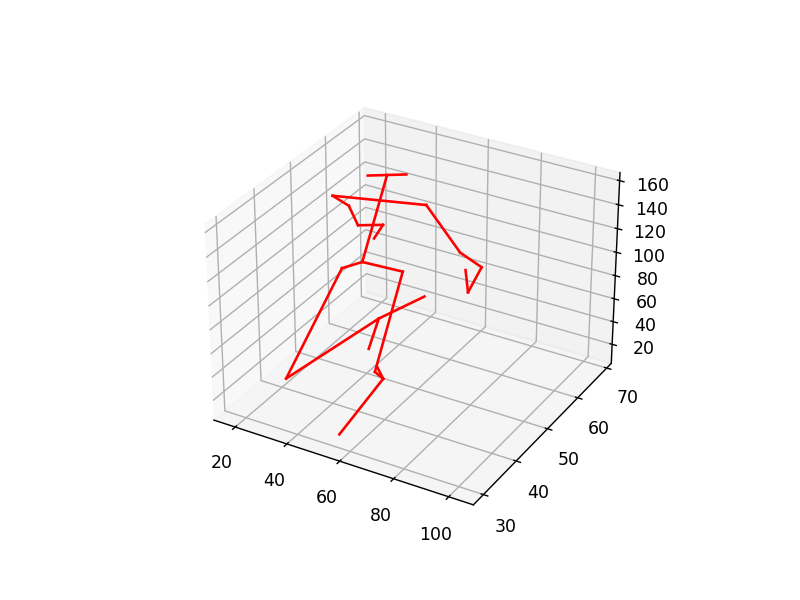

<IPython.core.display.Javascript object>


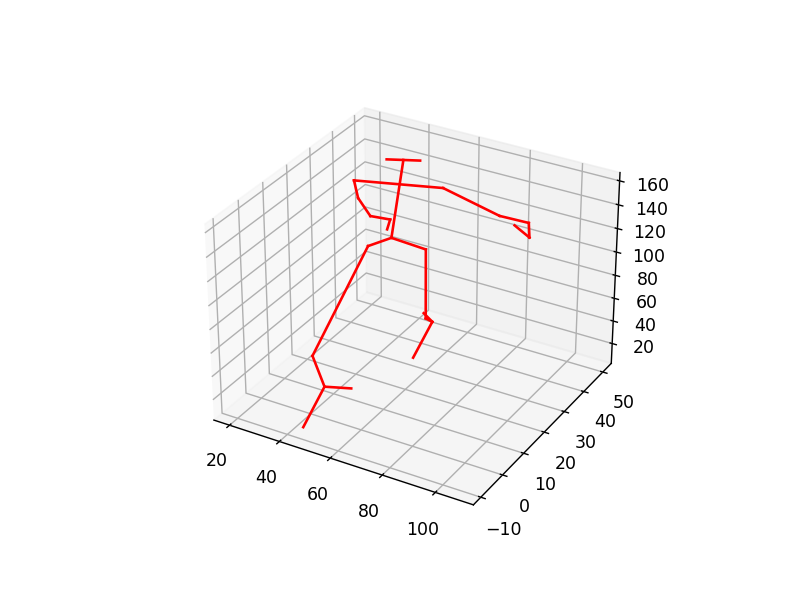

<IPython.core.display.Javascript object>


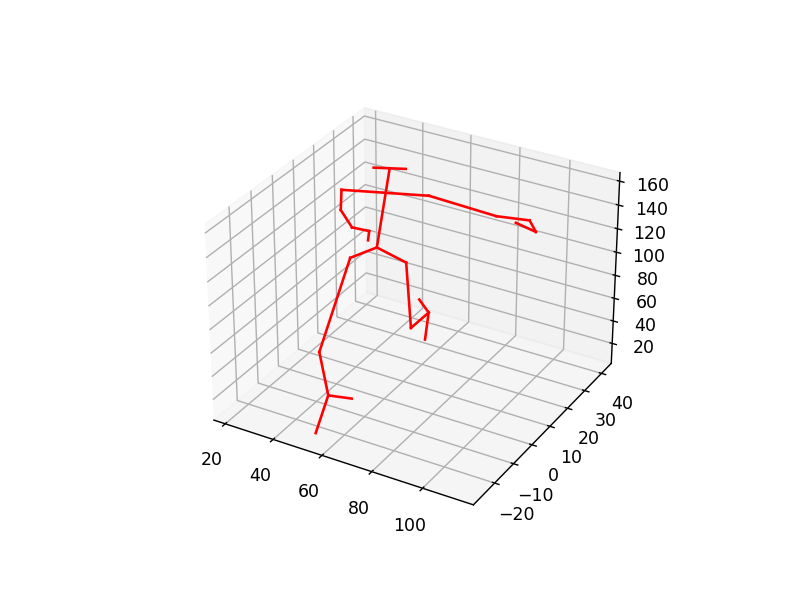

<IPython.core.display.Javascript object>


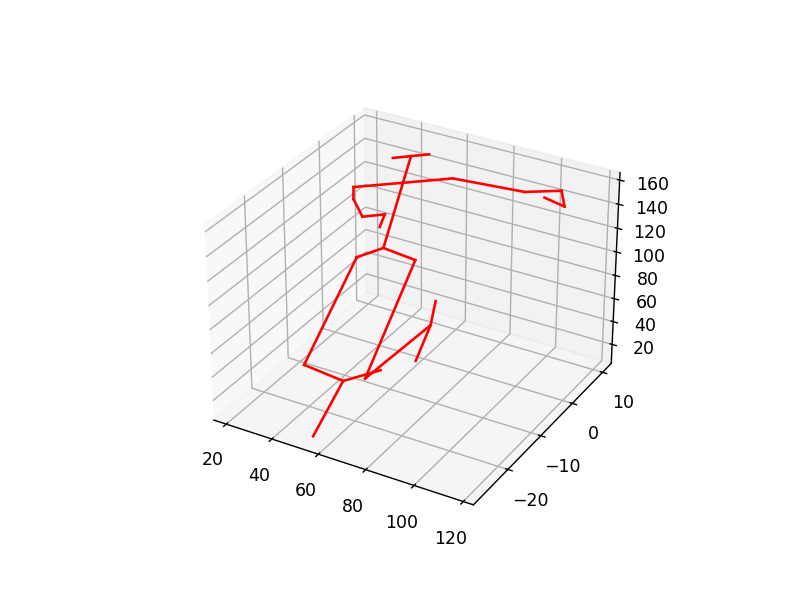

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

moves, uid, suid = dataset.__getitem__(0)
moves = moves*dataset.std + dataset.mean
skeletons = moves.numpy()
n=len(skeletons)
print(n)
plt.ion()
bone_list = [[1, 2],[4, 5], [5, 6], [6, 7], [4, 13], [13, 14], [14, 15], [15, 16], [3, 8], [8, 9], [9, 10], [10, 12], [10, 11], [3, 17], [17, 18], [18, 19], [19, 21], [19, 20],[7,23],[16,22]]
bone_list = np.array(bone_list) - 1
for i in range(n):
    plt.figure()
    skeleton=skeletons[i].reshape(23,3)
    head=np.add(skeleton[0],skeleton[1])/2
    ax = plt.axes(projection='3d')
    ax.plot3D([skeleton[2][2],head[2]], [skeleton[2][0], head[0]],[skeleton[2][1], head[1]], 'r')
    for bone in bone_list:
        ax.plot3D([skeleton[bone[0]][2],skeleton[bone[1]][2]], [skeleton[bone[0]][0], skeleton[bone[1]][0]],[skeleton[bone[0]][1], skeleton[bone[1]][1]], 'r')
    plt.show()

10


<IPython.core.display.Javascript object>


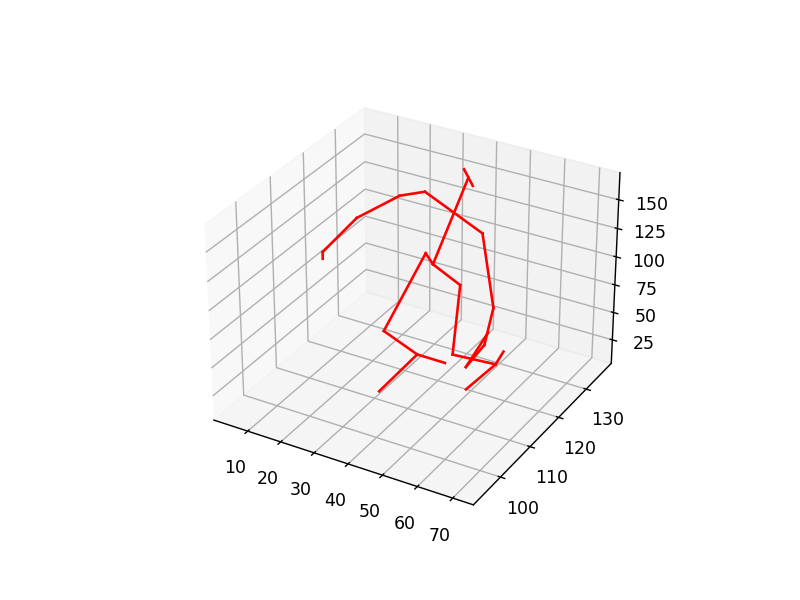

<IPython.core.display.Javascript object>


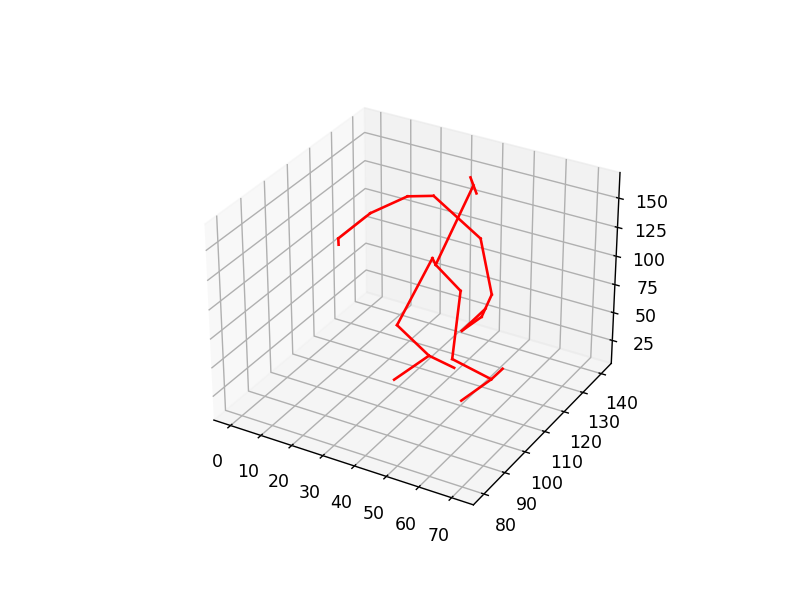

<IPython.core.display.Javascript object>


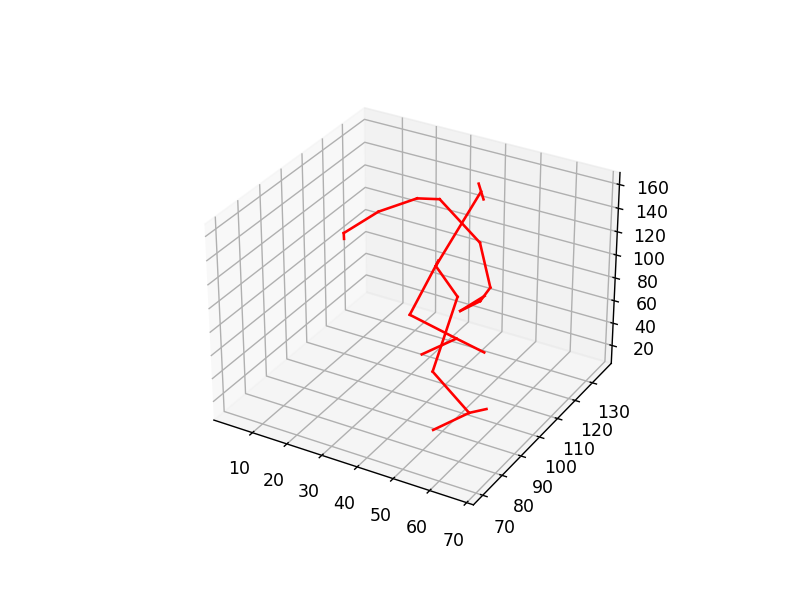

<IPython.core.display.Javascript object>


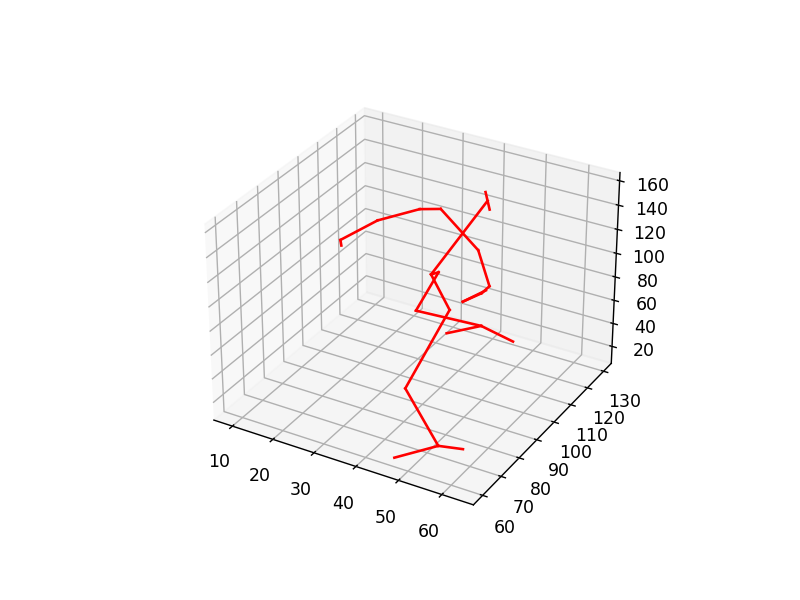

<IPython.core.display.Javascript object>


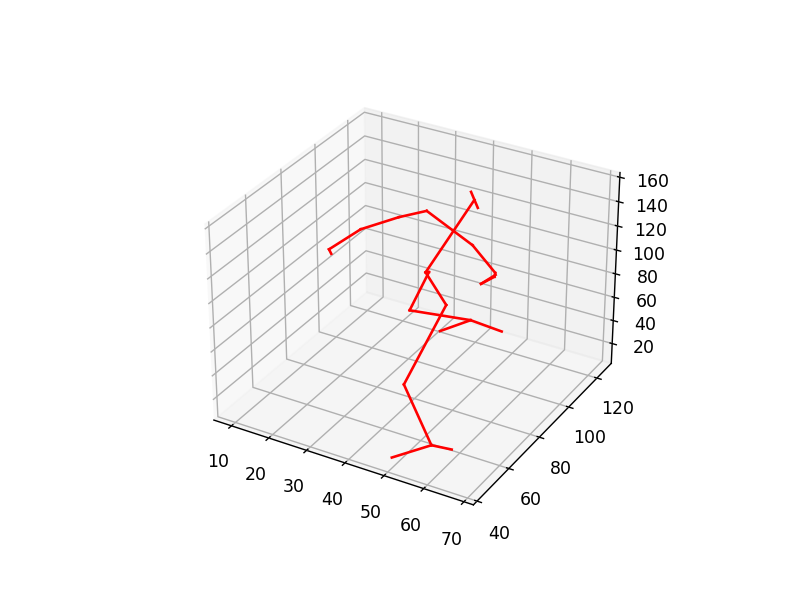

<IPython.core.display.Javascript object>


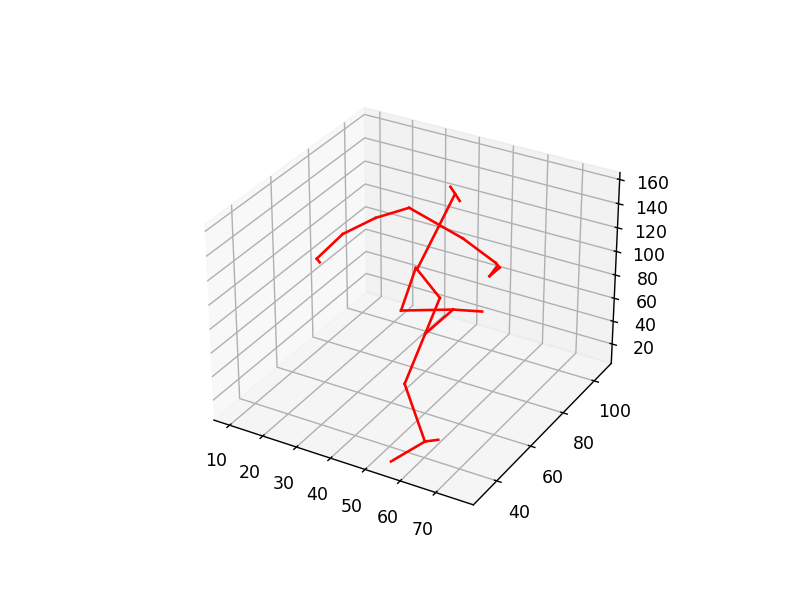

<IPython.core.display.Javascript object>


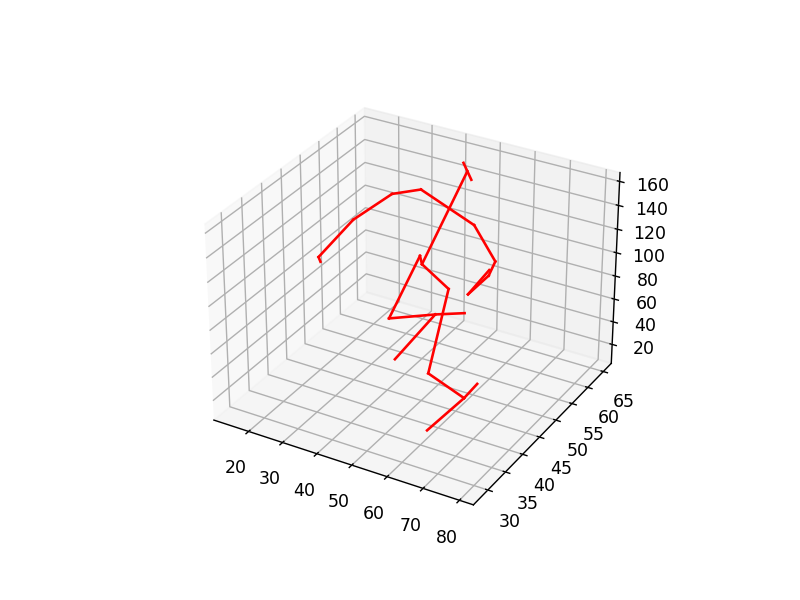

<IPython.core.display.Javascript object>


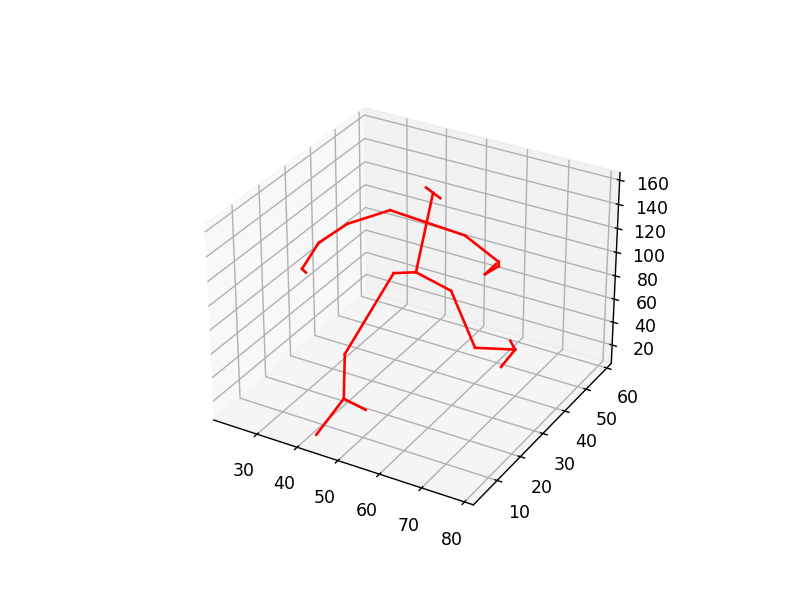

<IPython.core.display.Javascript object>


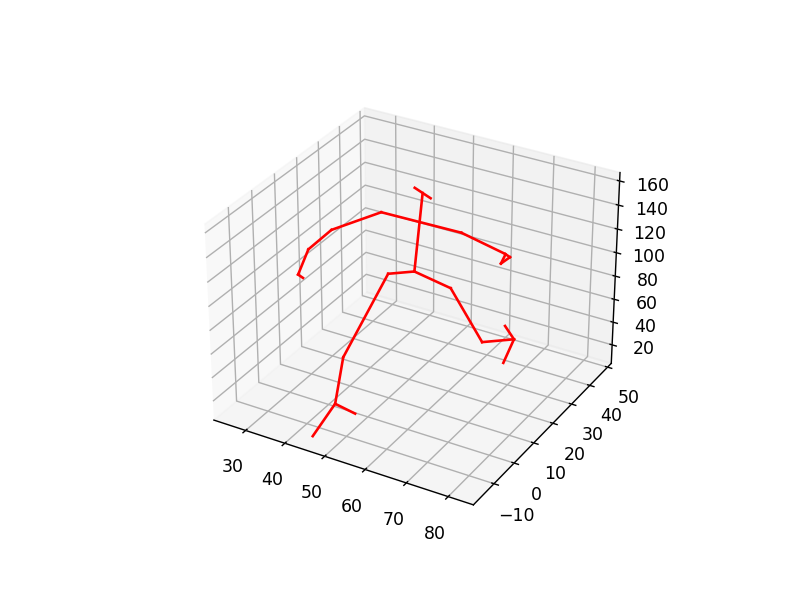

<IPython.core.display.Javascript object>


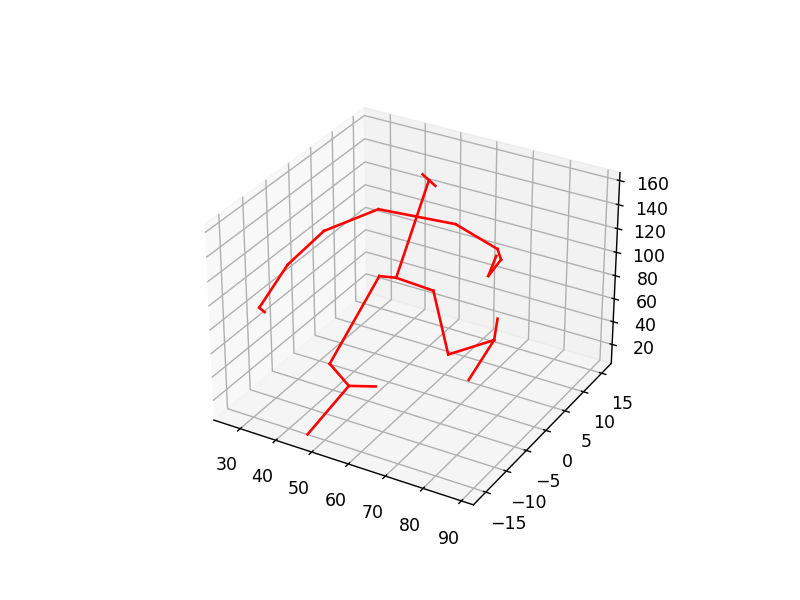

In [12]:
moves, uid, suid = dataset.__getitem__(0)
skeletons = (model(moves.to(device)).detach().cpu()*dataset.std + dataset.mean).numpy()
n=len(skeletons)
print(n)
plt.ion()
for i in range(n):
    plt.figure()
    skeleton=skeletons[i].reshape(23,3)
    head=np.add(skeleton[0],skeleton[1])/2
    ax = plt.axes(projection='3d')
    ax.plot3D([skeleton[2][2],head[2]], [skeleton[2][0], head[0]],[skeleton[2][1], head[1]], 'r')
    for bone in bone_list:
        ax.plot3D([skeleton[bone[0]][2],skeleton[bone[1]][2]], [skeleton[bone[0]][0], skeleton[bone[1]][0]],[skeleton[bone[0]][1], skeleton[bone[1]][1]], 'r')
    plt.show()

In [15]:
(skeleton-skeleton.mean(axis=0))/skeleton.std(axis=0)

array([[ 1.15814888,  1.24885474, -0.24991544],
       [ 0.95013292,  1.22946283,  0.03666541],
       [-0.27009633,  0.35607039,  0.02128416],
       [ 0.57415221,  0.85309048, -0.64236748],
       [ 0.59046969,  0.30090104, -1.49586863],
       [-0.28664304,  0.09674549, -1.62323345],
       [-1.32763894, -0.10447378, -1.52953945],
       [ 0.06893635,  0.13260339, -0.39301314],
       [-1.06099914, -0.77411946, -0.60813867],
       [-0.43644212, -1.38267296, -0.63278556],
       [-0.05322055, -1.48495761, -0.40308867],
       [-1.82531642, -1.49829161, -0.58054824],
       [ 0.52491749,  0.9648187 ,  0.52745107],
       [-0.06136317,  1.0631186 ,  1.38923093],
       [-0.60830566,  1.20105903,  1.67326558],
       [-1.19435296,  1.2254392 ,  1.751567  ],
       [ 0.02706893,  0.16747017,  0.43313856],
       [ 0.08217897, -0.73987576,  0.63366253],
       [ 1.71033632, -1.20268408,  0.61092581],
       [ 2.37693435, -1.21106481,  0.37427425],
       [ 0.86978652, -1.47146145,  0.595

In [ ]:
datasetx = TANG(seq_len=sequence_length, dataset_location='data/', normalize=False)
print(datasetx.__len__())
del datasetx

In [ ]:
moves, uid, suid = datasetx.__getitem__(0)
skeletons = moves.numpy()
n=len(skeletons)
print(n)
plt.ion()
bone_list = [[1, 2],[4, 5], [5, 6], [6, 7], [4, 13], [13, 14], [14, 15], [15, 16], [3, 8], [8, 9], [9, 10], [10, 12], [10, 11], [3, 17], [17, 18], [18, 19], [19, 21], [19, 20],[7,23],[16,22]]
bone_list = np.array(bone_list) - 1
for i in range(n):
    plt.figure()
    skeleton=skeletons[i].reshape(23,3)
    print(skeleton.shape)
    print(skeleton)
    head=np.add(skeleton[0],skeleton[1])/2
    ax.plot3D([skeleton[3][2],head[2]], [skeleton[3][0], head[0]],[skeleton[3][1], head[1]])
    ax = plt.axes(projection='3d')
    for bone in bone_list:
        ax.plot3D([skeleton[bone[0]][2],skeleton[bone[1]][2]], [skeleton[bone[0]][0], skeleton[bone[1]][0]],[skeleton[bone[0]][1], skeleton[bone[1]][1]], 'r')
    plt.show()